In [14]:
import os
import pickle
import blosc
import matplotlib.pyplot as plt

def decompress_data_blosc(compressed_data):
    """
    Decompresses the data structure using blosc.
    """
    # Decompress and deserialize
    serialized_data = blosc.decompress(compressed_data)
    data = pickle.loads(serialized_data)
    return data

def open_pickle_file(file_path, ssh_client=None):
    """
    Opens a single pickle file and returns its content.
    Supports both local and remote file reading via SSH.
    
    :param file_path: Path to the pickle file.
    :param ssh_client: Paramiko SSH client for remote access (required if remote=True).
    :return: Loaded pickle data.
    """
    if ssh_client:
        if ssh_client is None:
            raise ValueError("SSH client must be provided for remote access.")
        
        with ssh_client.open_sftp() as sftp:
            with sftp.file(file_path, 'rb') as file:
                return pickle.load(file)
    else:
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File not found: {file_path}")
        
        with open(file_path, 'rb') as file:
            return pickle.load(file)
    
def parse_and_plot_rate(directory, start_epoch, num_seconds, ssh_client= None):
    """
    Parses pickle files in the directory starting from a given epoch time and plots the rate per second.
    
    :param directory: Path to the directory containing pickle files.
    :param start_epoch: Starting epoch time (integer, ignoring fractions).
    :param num_seconds: Number of seconds to parse and plot.
    """
     
    rate_data = []
    time_labels = []
    
    for i in range(num_seconds):
        epoch_time = start_epoch + i
        
        # Find the first file that starts with this epoch time
        matching_files = [f for f in os.listdir(directory) if f.startswith(str(epoch_time)) and f.endswith('.pkl')]
        if matching_files:
            file_path = os.path.join(directory, matching_files[0])
            data = open_pickle_file(file_path, ssh_client)
            decomp_data = decompress_data_blosc(data)
            rate_data.append(len(decomp_data))
            time_labels.append(str(epoch_time))
        else:
            rate_data.append(0)
            time_labels.append(str(epoch_time))
    
    # Plot the results
    plt.figure(figsize=(10, 5))
    plt.plot(time_labels, rate_data, marker='o', linestyle='-')
    plt.xlabel("Epoch Time (s)")
    plt.ylabel("Rate per Second")
    plt.title("Rate per Second Over Time")
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()


In [13]:
alice_data_path = 'data/2/'
file_name = '1741698796.0721729.pkl'  # Change this to the specific file you want to open
file_path = os.path.join(alice_data_path, file_name)

data = open_pickle_file(file_path)
decomp_data = decompress_data_blosc(data)

# Print or process the data
print(f"Data from {file_name}:")
print(decomp_data)
print(len(decomp_data))
print("-" * 50)


Data from 1741698796.0721729.pkl:
[5.53837744e+04 5.55403652e+05 1.05539653e+06 ... 9.99998556e+11
 9.99999056e+11 9.99999555e+11]
2000000
--------------------------------------------------


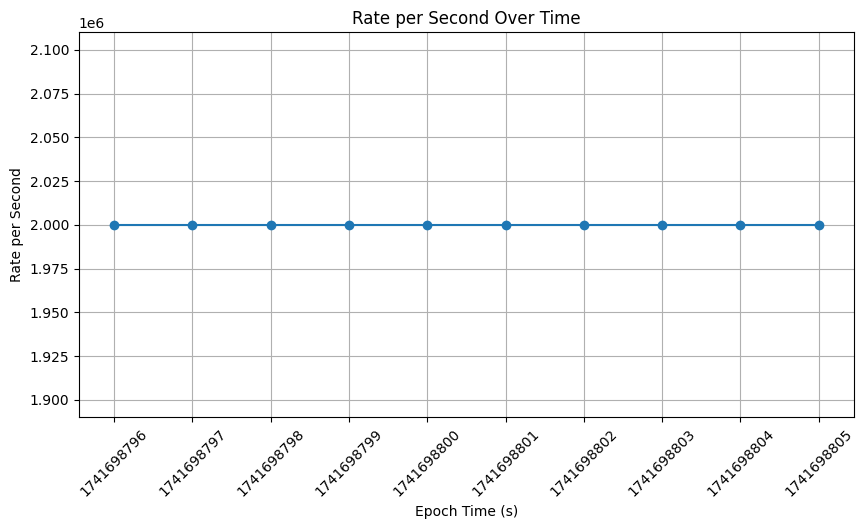

In [19]:
# Example usage
alice_data_path = 'data/2/'
start_epoch = 1741698796  # Starting second
num_seconds = 10  # Number of next seconds to plot

parse_and_plot_rate(alice_data_path, start_epoch, num_seconds)

In [ ]:
# use with remote stored data
import paramiko

ssh = paramiko.SSHClient()
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh.connect(hostname="your.remote.server", username="user", password="password")

alice_data_path = 'data/2/'
start_epoch = 1741698796  # Starting second
num_seconds = 10  # Number of next seconds to plot

parse_and_plot_rate(alice_data_path, start_epoch, num_seconds, ssh)